In [1]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
#!pip install -r requirements.txt

## PPO Training

In [2]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing

from collections import defaultdict

# Information
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Torch
import torch
from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import nn
from torch.distributions import Bernoulli, OneHotCategorical
from tensordict import TensorDict

# TorchRL
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import TransformedEnv, Compose, StepCounter 
from torchrl.envs.transforms import RemoveEmptySpecs
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE

# Environment
from Environment.MazeEnv import TorchRLMazeEnv

# Other
import uuid
import os
import json

In [3]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
# Model hyper-parameters
lr = 3e-3
max_grad_norm = 1.0

# Environment hyper-parameters
env_width = 128
env_height = 72
batches = 1 # Number of batches
size = 1 # Size of each batch

# Collector hyper-parameters
max_frames = 128
frames_per_batch = batches * size * max_frames # number of frames collected per batch
total_frames = frames_per_batch * 2048  # total number of frames to collect

# PPO hyper-parameters
sub_batch_size = max_frames / 2  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 16 # optimization steps per batch of data collected
clip_epsilon = ( 0.2 )  # clip value for PPO loss
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Checkpoint saving parameters
checkpoint_interval = 8
filename = ""


### Creating the environment

In [4]:
env = TorchRLMazeEnv(width=env_width, height=env_height, batches=batches, size=size, device=device, show_windows=True)

#check_env_specs(env)

#env.rollout(3)

### Creating the model

In [5]:
class MazeCNN(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, device=device),  # [3,72,128] -> [32,17,31]
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, device=device), # [32,17,31] -> [64,7,14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, device=device), # [32,17,31] -> [64,7,14]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2, device=device), # [32,17,31] -> [64,7,14]
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2, stride=1, device=device), # [64,7,14] -> [64,5,12]
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2, stride=1, device=device), # [64,7,14] -> [64,5,12]
            nn.ReLU(),
            nn.Flatten(start_dim=1),
        )

        # Calculate flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 72, 128, device=device)
            n_flat = self.features(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(n_flat, 512, device=device),
            nn.ReLU(),
            nn.Linear(512, num_actions, device=device),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

# Transforms observations to logits using module
actor = TensorDictModule(
    module=MazeCNN(6),
    in_keys=["observation"],
    out_keys=["logits"],
)

# 
actor = ProbabilisticActor(
    module=actor,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=OneHotCategorical,
    return_log_prob=True,
    out_keys=["action"],
)

value = ValueOperator(
    module=MazeCNN(1),
    in_keys=["observation"],
)

In [6]:
collector = SyncDataCollector(
    env,
    actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    max_frames_per_traj=max_frames,
    reset_at_each_iter=True,
    split_trajs=False,
    device=device,
)

# replay_buffer = ReplayBuffer(
#     storage=LazyTensorStorage(max_size=frames_per_batch, device=device),
#     sampler=SamplerWithoutReplacement(),
#     batch_size=torch.Size([batches * size * frames_per_batch]),
# )

replay_buffer = []

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value, average_gae=True, device=device,
)

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=value,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
    device=device,
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 1e-4
)

logs = defaultdict(list)

#collector.rollout()

### Training

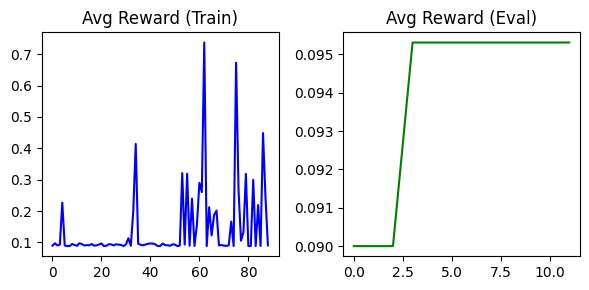

Training :   4%|▍         | 11392/262144 [05:38<2:17:31, 30.39it/s]

In [ ]:
pbar = tqdm(total=total_frames)
pbar.set_description("Training ")

import uuid

# Save model
# lastRunDir = list(os.listdir("checkpoints"))
# lastRunDir.sort()
# lastrun = int(lastRunDir[-1].split("_")[0])
runDir = f'./checkpoints/{uuid.uuid4()}'
os.mkdir(runDir)

eval_env = TorchRLMazeEnv(width=env_width, height=env_height, batches=1, size=1, device=device, show_windows=True)

# We get a batch of data from the collector
for i, tensordict_data in enumerate(collector):

    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(max_size=frames_per_batch, device=device),
        sampler=SamplerWithoutReplacement(),
        batch_size=torch.Size([batches * size * frames_per_batch]),
    )

    tensordict_data = tensordict_data.reshape(-1, *tensordict_data.shape[2:])     # [batches, frames, 3, 72, 128] -> [batches*frames, 3, 72, 128]

    for _ in range(num_epochs):
        advantage_module(tensordict_data)

        # Get the tensor to the correct shape

        flat_bs = tensordict_data.batch_size[0]
        obs = tensordict_data["observation"]
        obs = obs.reshape(flat_bs, *obs.shape[1:])
        action_shape    = tensordict_data["action"].shape[1:]
        logprob_shape   = tensordict_data["sample_log_prob"].shape[1:]
        flat_td = TensorDict(
            {
            "observation":    obs,
            "action":         tensordict_data["action"]
                                    .reshape(flat_bs, *action_shape),
            "sample_log_prob": tensordict_data["sample_log_prob"]
                                    .reshape(flat_bs, *logprob_shape),
            "state_value":    tensordict_data["state_value"]
                                    .reshape(flat_bs, 1),
            "value_target":   tensordict_data["value_target"]
                                    .reshape(flat_bs, 1),
            "advantage":      tensordict_data["advantage"]
                                    .reshape(flat_bs),
            },
            batch_size=torch.Size([flat_bs]),
            device=tensordict_data.device,
        )

        # Add the data to the replay buffer
        replay_buffer.extend(flat_td.cpu())

        # Sample sub-batches from the replay buffer
        for _ in range(int(frames_per_batch / sub_batch_size)):
            subdata = replay_buffer.sample(int(sub_batch_size))

            # Compute the loss
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            
            # Backpropagate and optimize
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["train_reward"].append( tensordict_data["next", "reward"].mean().item() )
    #logs["train_steps_min"].append( tensordict_data["step_count"].min().item() )
    #logs["train_steps_max"].append( tensordict_data["step_count"].max().item() )

    # Execute the policy without exploration
    if i % checkpoint_interval == 0:
        pbar.set_description("Evaluation ")
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # Run the env with the actors value
            eval_rollout = eval_env.rollout(256, actor)

            # Save the evaluation data
            logs["eval_reward"].append( eval_rollout["next", "reward"].mean().item() )
            #logs["eval_steps"].append( eval_rollout["step_count"].min().item() )
            del eval_rollout

            # Save a checkpoint
            filename = f'{runDir}/{i}.ch'
            checkpoint = {
                'model_state_dict': actor.module.state_dict(),
            }

            torch.save(checkpoint, filename)

    pbar.set_description("Training ")

    # Update plot data
    clear_output(wait=True)

    # Rebuild the figure from scratch
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes = axes.flatten()
    titles = [
        "Avg Reward (Train)", "Avg Reward (Eval)",
        #"Min Steps (Train)", "Max Steps (Train)",
    ]
    data = [
        (logs["train_reward"],   "blue"),
        (logs["eval_reward"],    "green"),
        #(logs["train_steps_min"],    "red"),
        #(logs["train_steps_max"],     "orange"),
    ]

    for ax, title, (y, color) in zip(axes, titles, data):
        ax.plot(y, color=color)
        ax.set_title(title)
        ax.relim()
        ax.autoscale_view()

    plt.tight_layout()

    # Display the new figure
    display(fig)
    plt.close(fig)

    # Learning rate scheduling
    #scheduler.step()
    
    # Update the progress bar
    pbar.update(tensordict_data.numel())

# Final save of the model
filename = f'{runDir}/_final.ch'
checkpoint = {
    'model_state_dict': actor.module.state_dict(),
}

torch.save(checkpoint, filename)

In [ ]:
# Load model for testing
if filename == "":
    # Load the last checkpoint of the last run
    anyID = list(os.listdir("checkpoints"))[-1]
    filename = "checkpoints/{}/_final.ch".format(anyID)
    runDir = f'./checkpoints/{anyID}'
else:
    with open(f'{runDir}/logs.json', 'w') as f:
        f.write(json.dumps(logs))

l_checkpoint = torch.load(filename)

actor.module.state_dict(l_checkpoint["model_state_dict"])

env = TorchRLMazeEnv(width=env_width, height=env_height, batches=1, size=1, device=device, show_windows=True)
env = TransformedEnv(env, Compose( RemoveEmptySpecs(), StepCounter() ))

env.rollout(512, actor)

In [ ]:
with open(f'{runDir}/logs.json', 'r') as f:
    logs = json.load(f)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.flatten()
titles = [
    "Avg Reward (Train)", "Avg Reward (Eval)",
    #"Min Steps (Train)", "Max Steps (Train)",
]
data = [
    (logs["train_reward"],   "blue"),
    (logs["eval_reward"],    "green"),
    #(logs["train_steps_min"],    "red"),
    #(logs["train_steps_max"],     "orange"),
]

for ax, title, (y, color) in zip(axes, titles, data):
    ax.plot(y, color=color)
    ax.set_title(title)
    ax.relim()
    ax.autoscale_view()

plt.tight_layout()